## Setup Notebook and Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")
%matplotlib inline

## Import Data

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

In [59]:
# Read the data and set the datetime as the index.
url = './input/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

Notice that we used `index_col` to set an index or primary key for our data. In this case, the index of each row will be set to the value of its `datetime` field.

We also ask Pandas to parse dates (if `parse_dates=True`, for the index only). So, rather than reading in a string, Pandas converts the index string to a `datetime` object.

In [60]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [61]:
# how many features are there?
bikes.shape[1]

11

#### "count" is a method in Pandas (and a very non-specific name), so it's best to name that column something else

In general, you may want to rename columns if it is not obvious what might be stored in them. Although we will only rename the target column here, a few examples might be to rename:

| old name | new name |
| ---    | --- |
| temp | temp_celcius
| windspeed | windspeed_knots
| casual | num_casual_users
| registered | num_registered_users
| season | season_num
| holiday | is_holiday
| workingday | is_workingday
| humidity | humidity_percent

Without having to check, these new names make it obvious what is stored in each column. The downside is slightly longer column names, which could affect table readability in Jupyter. It would be ideal to use very specific names in CSV files to assist others reading them. In your own code, use whatever makes sense for your work -- if you are viewing lots of Pandas tables, you may want to use shorter names. However, readable specific names are preferred in Python code since it prevents mistakes.

In [62]:
bikes.rename(columns={'count':'total_rentals', 'casual':'num_casual_users', 'registered':'num_registered_users'}, inplace=True)

In [63]:
bikes.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'num_casual_users', 'num_registered_users',
       'total_rentals'],
      dtype='object')

## Visualizing data

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

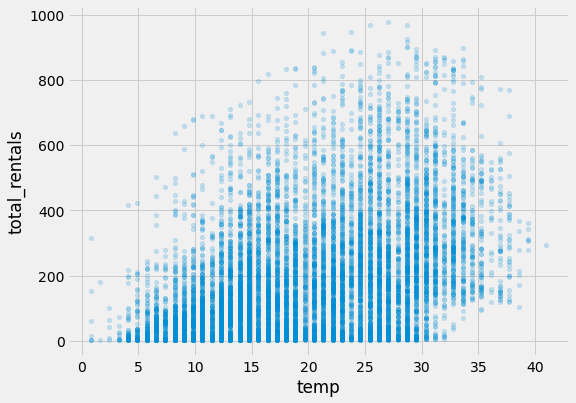

In [7]:
bikes.plot(kind='scatter', x='temp', y='total_rentals', alpha=0.2)

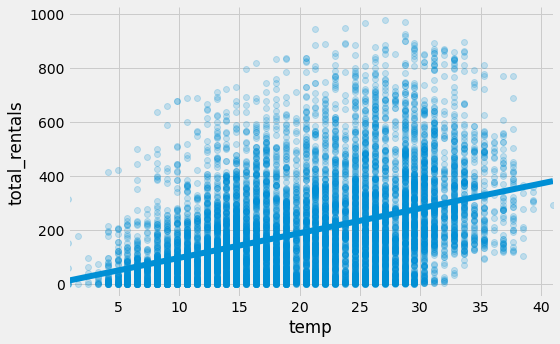

In [10]:
# plotting a regression line

sns.lmplot(x='temp', y='total_rentals', data=bikes, aspect=1.6, scatter_kws={'alpha':0.2});

## Linear Regression in sklearn

In [11]:
# single variable linear regression
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total_rentals

X.head()

,temp
datetime,
2011-01-01 00:00:00,9.84
2011-01-01 01:00:00,9.02
2011-01-01 02:00:00,9.02
2011-01-01 03:00:00,9.84
2011-01-01 04:00:00,9.84


In [12]:
y.head()

datetime
2011-01-01 00:00:00    16
2011-01-01 01:00:00    40
2011-01-01 02:00:00    32
2011-01-01 03:00:00    13
2011-01-01 04:00:00     1
Name: total_rentals, dtype: int64

## sklearn 4-steps ML

***Step 1:*** Import the model class

In [13]:
from sklearn.linear_model import LinearRegression

***Step 2:*** Instantiate the estimator

In [14]:
model = LinearRegression()

***Step 3:*** Fit the model with data (training)

In [15]:
model.fit(X,y)

LinearRegression()

***Step 4:*** Predict response for new inputs

In [20]:
model.predict([[10]])

array([97.75161777])

In [22]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
model.predict(np.array([10,15,20,25]).reshape(4,1))

array([ 97.75161777, 143.60432018, 189.45702259, 235.309725  ])

Let's look at the _intercept_ and _coeff_ : bring back the algebra!

In [43]:
print("intercept: {0}, coeff: {1}".
      format(model.intercept_, model.coef_))

intercept: 120.95104733487193, coeff: [ 2.42814694 -0.93380574  2.20114416]


Recall that each model always contains some amount of random irreducible error $\epsilon$. So, given a prediction $\hat{y}$, the actual $y = \hat{y} + \epsilon$. Below, we will assume $y$ is exactly linear.

- We are often taught the formula for a line is: $y = mx + b$.
- Note this can alternatively be written: $y = \beta_0 + \beta_1 x$.

Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the "temp" coefficient ($\beta_1$):

- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\beta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in total rentals.
- $\beta_1$ would be **zero** if temperature is not associated with total rentals.

---

---

Here, we will generalize this to $n$ independent variables as follows:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response.
- $\beta_0$ is the intercept.
- $\beta_1$ is the coefficient for $x_1$ (the first feature).
- $\beta_n$ is the coefficient for $x_n$ (the nth feature).
- $\epsilon$ is the _error_ term

A practical example of this applied to our data might be:

$total\_rides = 20 + -2 \cdot temp + -3 \cdot windspeed\ +\ ...\ +\ 0.1 \cdot registered$

This equation is still called **linear** because the highest degree of the independent variables (e.g. $x_i$) is 1. Note that because the $\beta$ values are constants, they will not be independent variables in the final model, as seen above.


---

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are trying to find the line (mathematically) that minimizes the **sum of squared residuals** (or "sum of squared errors").
- Once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](./images/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.


In [45]:
# multiple variables linear regression
feature_cols = ['temp', 'season', 'weather', 'humidity']

X = bikes[feature_cols]
y = bikes.total_rentals

X.head()

,temp,season,weather,humidity
datetime,,,,
2011-01-01 00:00:00,9.84,1,1,81
2011-01-01 01:00:00,9.02,1,1,80
2011-01-01 02:00:00,9.02,1,1,80
2011-01-01 03:00:00,9.84,1,1,75
2011-01-01 04:00:00,9.84,1,1,75


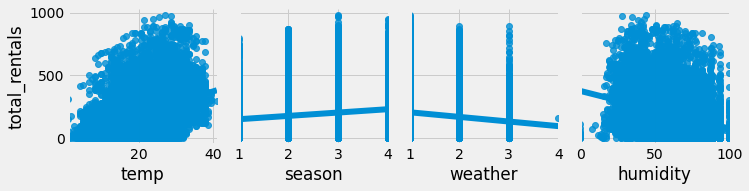

In [46]:
# multiple scatterplots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total_rentals', kind='reg');

Let's look at the coefficients and try to "understand" what they mean

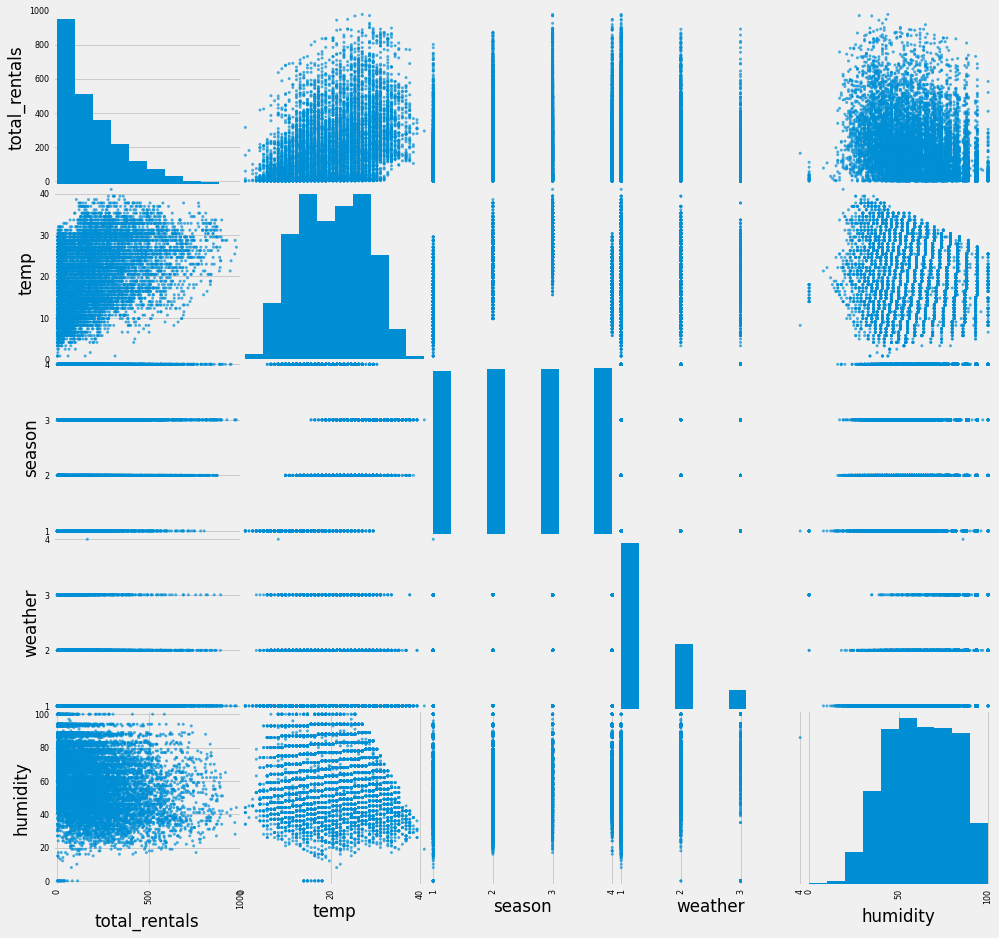

In [49]:
# scatter_matrix does a pairplot of *every* column
import warnings
warnings.filterwarnings('ignore') ## not ideal but will deal with this later

grr = pd.plotting.scatter_matrix(bikes[['total_rentals'] + feature_cols], figsize=(15, 15), alpha=0.7)

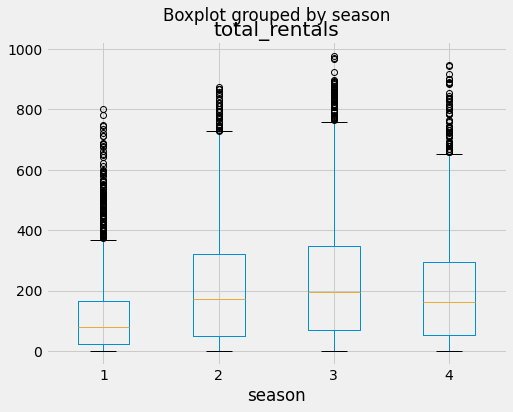

In [50]:
# Box plot of rentals, grouped by season
bikes.boxplot(column='total_rentals', by='season');

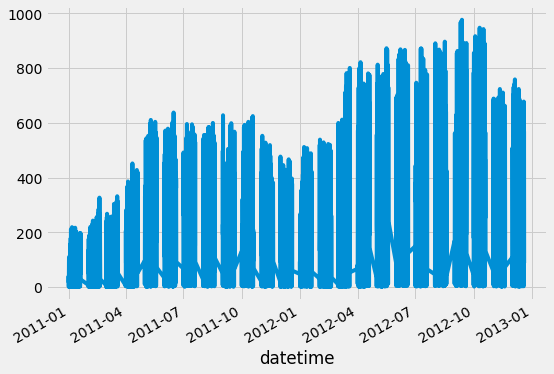

In [51]:
# Line plot of rentals
bikes.total_rentals.plot();

## Intuition on bike rentals

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

Look at the correlation matrix for the bikes DataFrame.

In [52]:
# Correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,num_casual_users,registered,total_rentals
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
num_casual_users,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


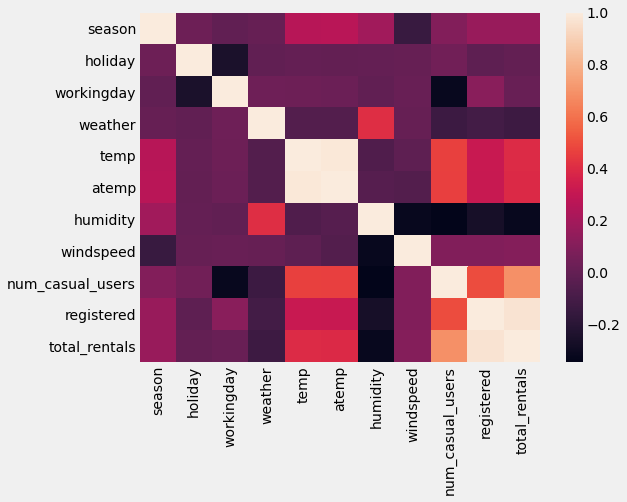

In [53]:
# Visualize correlation matrix in Seaborn using a heat map.
sns.heatmap(bikes.corr())

## Multiple Variable Linear Regression

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

In [56]:
# Create a list of features.
feature_cols = ['temp', 'season', 'weather', 'humidity']

# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols, linreg.coef_)))

159.5206878612979
[('temp', 7.86482499247745), ('season', 22.538757532466768), ('weather', 6.670302035923734), ('humidity', -3.118873382396501)]


## Curse of Multicolinearity

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other.

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.



In [67]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,num_casual_users,num_registered_users,total_rentals
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

                      temp     atemp  num_casual_users
temp              1.000000  0.984948          0.467097
atemp             0.984948  1.000000          0.462067
num_casual_users  0.467097  0.462067          1.000000
AxesSubplot(0.08,0.07;0.696x0.81)


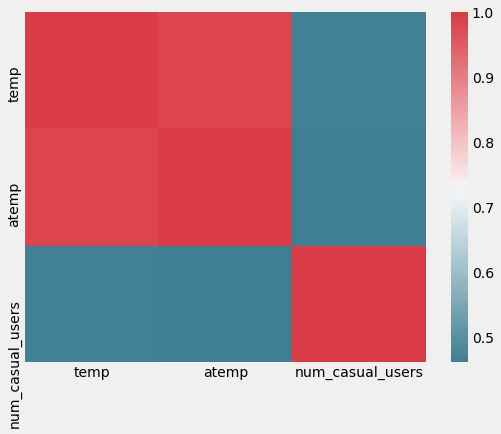

In [66]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'num_casual_users']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

In [68]:
# Create a list of features.
feature_cols = ['temp', 'atemp']

In [69]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

4.2481326458035085
[8.19865874 0.90720808]


In [70]:
## what do these coefficients tell you about temp vs atemp?